# Local biases in specific hot-humid and hot-dry regions
- It is revealing to explore the bias structure in a more detailed way for two different end-member regimes relevant to heat stress, corresponding to hot-humid and hot-dry climates.


- Here Bangladesh and east Sahara are selected for assessing sWBGT/ESI biases. Each region is characterized by a 2° x 2° lat/lon box.


- In this notebook, we will reproduce Figure 6 in "Explicit Calculations of Wet Bulb Globe Temperature compared with approximations and why it matters for labor productivity" by Qinqin Kong and Matthew Huber. 

In [14]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmaps
from scipy import stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import warnings
warnings.filterwarnings("ignore")

### read in data

In [16]:
# read in diurnal cycle for each region
diurnal_cycle=xr.open_dataset('/scratch/brown/kong97/paper_data/earthfuture_kong_huber_2021/diurnal_cycle.nc')
# read in daytime and nighttime series for each region
ts=xr.open_dataset('/scratch/brown/kong97/paper_data/earthfuture_kong_huber_2021/region_daytime_nighttime_series.nc').time_series
# read in heatmap frequency of biases for each region
freq=xr.open_dataset('/scratch/brown/kong97/paper_data/earthfuture_kong_huber_2021/heatmap.nc').freq

In [17]:
# calculate correlation coefficient
corr_ESHR_swbgt=stats.pearsonr(ts.sel(region='ESHR').sel(diurnal='daytime').sel(var='SWBGT_bias').dropna('index'),
               ts.sel(region='ESHR').sel(diurnal='daytime').sel(var='WBGT').dropna('index'))
corr_ESHR_esi=stats.pearsonr(ts.sel(region='ESHR').sel(diurnal='daytime').sel(var='ESI_bias').dropna('index'),
               ts.sel(region='ESHR').sel(diurnal='daytime').sel(var='WBGT').dropna('index'))

corr_BGDH_swbgt=stats.pearsonr(ts.sel(region='BGDH').sel(diurnal='daytime').sel(var='SWBGT_bias').dropna('index'),
               ts.sel(region='BGDH').sel(diurnal='daytime').sel(var='WBGT').dropna('index'))
corr_BGDH_esi=stats.pearsonr(ts.sel(region='BGDH').sel(diurnal='daytime').sel(var='ESI_bias').dropna('index'),
               ts.sel(region='BGDH').sel(diurnal='daytime').sel(var='WBGT').dropna('index'))

### Reproduce Figure 6

In [30]:
# scatter plot function for daytime
def scatter_plot_daytime(axis,x,y,c,xlabel,metric,vmin,vmax,cmap):
    g=axis.scatter(x,y,c=c,s=0.2,alpha=0.5,rasterized=True,cmap=cmap,vmin=vmin,vmax=vmax)
    axis.set_xlim(10, 42)
    axis.set_ylim(-12,12)
    axis.boxplot(y,sym='',positions=[40],whis=(1, 99),widths=3) # add boxplot
    axis.axhline(y=0,lw=0.8,color='k')
    if xlabel: # control if add label and ticks on x-axis
        axis.set_xlabel('WBGT ($^\circ$C)',fontsize=12)
        axis.set_xticks([10,20,30,40])
        axis.set_xticklabels(('10', '20', '30','40'))
    else:
        axis.set_xticks([])
        axis.set_xlabel('')
    
    axis.set_yticks([])
    axis.set_ylabel('')
    axis.tick_params(axis='both', which='major', labelsize=12)
    cbaxes = inset_axes(axis, width="4%", height="25%", loc=3) 
    plt.colorbar(g,cax=cbaxes, ticks=[vmin,vmax])
    
               
# scatter plot function for nighttime
def scatter_plot_nighttime(axis,x,y,xlabel,metric):
    axis.scatter(x,y,s=0.2,alpha=0.5,rasterized=True,color='k')
    axis.set_xlim(10, 42)
    axis.set_ylim(-12,12)
    axis.boxplot(y,sym='',positions=[40],whis=(1, 99),widths=3)
    axis.axhline(y=0,lw=0.8,color='k')
    if xlabel:
        axis.set_xlabel('WBGT ($^\circ$C)',fontsize=12)
        axis.set_xticks([10,20,30,40])
        axis.set_xticklabels(('10', '20', '30','40'))
    else:
        axis.set_xticks([])
        axis.set_xlabel('')
    axis.set_yticks([])
    axis.set_ylabel('')
    axis.tick_params(axis='both', which='major', labelsize=12)  

# heatmap function to show the frequency distribution    
def heatmap(axis,x,y,data,cmap,norm,xlabel):
    g=axis.pcolormesh(x,y,data,cmap=cmap,norm=norm)
    axis.set_yticks([])
    axis.set_ylabel('')
    axis.set_xlim(10, 42)
    axis.set_ylim(-12,12)
    axis.axhline(y=0,lw=0.8,color='k')
    if xlabel:
        axis.set_xlabel('WBGT ($^\circ$C)',fontsize=12)
        axis.set_xticks([10,20,30,40])
        axis.set_xticklabels(('10', '20', '30','40'))
    else:
        axis.set_xticks([])
        axis.set_xlabel('')
    return g

# plot the diurnal cycle
def line_plot(axis,x,y,y01,y99,xlabel,ylabel,metric):
    axis.plot(x,y,linewidth=2,color='black')
    axis.fill_between(x,y01,y99,alpha=0.2,color='black')
    axis.axhline(y=0,lw=0.8,color='k')
    if xlabel:
        axis.set_xlabel('Hours',fontsize=12)
        axis.set_xticks([0,4,8,12,16,20,24])
    else:
        axis.set_xticks([])
        axis.set_xlabel('')
    if ylabel:
        if metric=='sWBGT':
            axis.set_ylabel('sWBGT-WBGT ($^\circ$C)',fontsize=12)
        else:
            axis.set_ylabel('ESI-WBGT ($^\circ$C)',fontsize=12)
        axis.set_ylim(-12,12)
        axis.set_yticks([-10,-5,0,5,10])
    else:
        axis.set_yticks([])
        axis.set_ylabel('')
    axis.tick_params(axis='both', which='major', labelsize=12)

# make the whole plot    
def plot(diurnal_cycle,ts,freq):
    
    # create a figure and add axis
    fig, ([ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8],[ax9,ax10,ax11,ax12],[ax13,ax14,ax15,ax16]) = plt.subplots(4,4,figsize=[15, 10])

    # adjust relative positions of subplots
    fig.subplots_adjust(wspace=0.1,hspace=0.3)
    # choose colormap
    color=np.array([[49,54,149],
                    [69,117,180],
                    [116,173,209],
                    [171,217,233],
                    [224,243,248],
                    [255,255,191],
                    [254,224,144],
                    [253,174,97],
                    [244,109,67],
                    [215,48,39],
                    [165,0,38]])
    cmap=mpl.colors.ListedColormap(color/255.)
    
    # add annotates
    anno_opts = dict(xy=(0, 1.1), xycoords='axes fraction',va='center', ha='center')
    num=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p']
    i=0
    for axis in (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8, ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16):
        axis.annotate(num[i], **anno_opts,fontsize=14)
        i+=1
    ######## Bangladesh ###########
    # diurnal cycle for sWBGT bias at Bangladesh
    line_plot(ax1,diurnal_cycle.BGDH['hour'],diurnal_cycle.BGDH.sel(var='SWBGT_bias').sel(quantile='mean'),
              diurnal_cycle.BGDH.sel(var='SWBGT_bias').sel(quantile='0.01'),diurnal_cycle.BGDH.sel(var='SWBGT_bias').sel(quantile='0.99'),
              False,True,'sWBGT')
    
    # daytime scatter for sWBGT bias at Bangladesh
    scatter_plot_daytime(ax2,ts.sel(region='BGDH').sel(diurnal='daytime').sel(var='WBGT').dropna('index')-273.15,
                         ts.sel(region='BGDH').sel(diurnal='daytime').sel(var='SWBGT_bias').dropna('index'),
                         ts.sel(region='BGDH').sel(diurnal='daytime').sel(var='rsds_interp').dropna('index'),
                         False,'sWBGT',10,900,cmaps.cmocean_solar)
    ax2.text(18,9,r'r='+str(round(corr_BGDH_swbgt[0],2)),horizontalalignment='center',verticalalignment='center',
            fontsize=14)
    # nighttime scatter for sWBGT bias at Bangladesh
    scatter_plot_nighttime(ax3,ts.sel(region='BGDH').sel(diurnal='nighttime').sel(var='WBGT').dropna('index')-273.15,
                         ts.sel(region='BGDH').sel(diurnal='nighttime').sel(var='SWBGT_bias').dropna('index'),
                         False,'sWBGT')
    
    # set colorbar scale
    levels=[0,0.01,0.05,0.1,0.5,1,2,3,4,6,10]
    norm=mpl.colors.BoundaryNorm(levels,ncolors=len(levels),extend='max')
    
    # heatmap for daytime sWBGT biases at Bangladesh
    X=np.arange(10,42.1,1)
    Y=np.arange(-12,12.1,1)
    heatmap(ax4,X,Y,freq.sel(region='BGDH').sel(var='SWBGT_bias'),cmap,norm,False)
    
    # diurnal cycle for ESI bias at Bangladesh
    line_plot(ax5,diurnal_cycle.BGDH['hour'],diurnal_cycle.BGDH.sel(var='ESI_bias').sel(quantile='mean'),
              diurnal_cycle.BGDH.sel(var='ESI_bias').sel(quantile='0.01'),diurnal_cycle.BGDH.sel(var='ESI_bias').sel(quantile='0.99'),
              False,True,'ESI')
    
    # daytime scatter for ESI bias at Bangladesh
    scatter_plot_daytime(ax6,ts.sel(region='BGDH').sel(diurnal='daytime').sel(var='WBGT').dropna('index')-273.15,
                         ts.sel(region='BGDH').sel(diurnal='daytime').sel(var='ESI_bias').dropna('index'),
                         ts.sel(region='BGDH').sel(diurnal='daytime').sel(var='wind10m').dropna('index'),
                         False,'ESI',0,8,cmaps.BlueDarkOrange18)
    ax6.text(18,9,r'r='+str(round(corr_BGDH_esi[0],2)),horizontalalignment='center',verticalalignment='center',
            fontsize=14)
    # nighttime scatter for ESI bias at Bangladesh
    scatter_plot_nighttime(ax7,ts.sel(region='BGDH').sel(diurnal='nighttime').sel(var='WBGT').dropna('index')-273.15,
                         ts.sel(region='BGDH').sel(diurnal='nighttime').sel(var='ESI_bias').dropna('index'),
                         False,'ESI')

    # heatmap for daytime ESI biases at Bangladesh
    X=np.arange(10,42.1,1)
    Y=np.arange(-12,12.1,1)
    h=heatmap(ax8,X,Y,freq.sel(region='BGDH').sel(var='ESI_bias'),cmap,norm,False)
    
    
    ########east Sahara###########
    # diurnal cycle for sWBGT bias at east Sahara
    line_plot(ax9,diurnal_cycle.ESHR['hour'],diurnal_cycle.ESHR.sel(var='SWBGT_bias').sel(quantile='mean'),
              diurnal_cycle.ESHR.sel(var='SWBGT_bias').sel(quantile='0.01'),diurnal_cycle.ESHR.sel(var='SWBGT_bias').sel(quantile='0.99'),
              False,True,'sWBGT')
    
    # daytime scatter for sWBGT bias at east Sahara
    scatter_plot_daytime(ax10,ts.sel(region='ESHR').sel(diurnal='daytime').sel(var='WBGT').dropna('index')-273.15,
                         ts.sel(region='ESHR').sel(diurnal='daytime').sel(var='SWBGT_bias').dropna('index'),
                         ts.sel(region='ESHR').sel(diurnal='daytime').sel(var='rsds_interp').dropna('index'),
                         False,'sWBGT',10,900,cmaps.cmocean_solar)
    ax10.text(18,9,r'r='+str(round(corr_ESHR_swbgt[0],2)),horizontalalignment='center',verticalalignment='center',
             fontsize=14)
    # nighttime scatter for sWBGT bias at east Sahara
    scatter_plot_nighttime(ax11,ts.sel(region='ESHR').sel(diurnal='nighttime').sel(var='WBGT').dropna('index')-273.15,
                         ts.sel(region='ESHR').sel(diurnal='nighttime').sel(var='SWBGT_bias').dropna('index'),
                         False,'sWBGT')
    
    # heatmap for daytime sWBGT biases at east Sahara
    X=np.arange(10,42.1,1)
    Y=np.arange(-12,12.1,1)
    heatmap(ax12,X,Y,freq.sel(region='ESHR').sel(var='SWBGT_bias'),cmap,norm,False)
    
    
    
    
    
    # diurnal cycle for ESI bias at east Sahara
    line_plot(ax13,diurnal_cycle.ESHR['hour'],diurnal_cycle.ESHR.sel(var='ESI_bias').sel(quantile='mean'),
              diurnal_cycle.ESHR.sel(var='ESI_bias').sel(quantile='0.01'),diurnal_cycle.ESHR.sel(var='ESI_bias').sel(quantile='0.99'),
              True,True,'ESI')
    
    # daytime scatter for ESI bias at east Sahara
    scatter_plot_daytime(ax14,ts.sel(region='ESHR').sel(diurnal='daytime').sel(var='WBGT').dropna('index')-273.15,
                         ts.sel(region='ESHR').sel(diurnal='daytime').sel(var='ESI_bias').dropna('index'),
                         ts.sel(region='ESHR').sel(diurnal='daytime').sel(var='wind10m').dropna('index'),
                         True,'ESI',0,8,cmaps.BlueDarkOrange18)
    ax14.text(18,9,r'r='+str(round(corr_ESHR_esi[0],2)),horizontalalignment='center',verticalalignment='center',
             fontsize=14)
    # nighttime scatter for ESI bias at east Sahara
    scatter_plot_nighttime(ax15,ts.sel(region='ESHR').sel(diurnal='nighttime').sel(var='WBGT').dropna('index')-273.15,
                         ts.sel(region='ESHR').sel(diurnal='nighttime').sel(var='ESI_bias').dropna('index'),
                         True,'ESI')
    # heatmap for daytime ESI biases at east Sahara
    X=np.arange(10,42.1,1)
    Y=np.arange(-12,12.1,1)
    h=heatmap(ax16,X,Y,freq.sel(region='ESHR').sel(var='ESI_bias'),cmap,norm,True)
    
    anno_opts = dict(xy=(-0.4, -0.2), xycoords='axes fraction',va='center', ha='center')
    ax1.annotate('BGDH', **anno_opts,fontsize=16,rotation=90)
    ax9.annotate('ESHR', **anno_opts,fontsize=16,rotation=90)
    
    # plot colorbar
    cb=fig.colorbar(h,ax=((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8),(ax9,ax10,ax11,ax12),(ax13,ax14,ax15,ax16)),orientation='vertical', pad=0.03,shrink=0.9,fraction=.09,ticks=[0,0.01,0.05,0.1,0.5,1,2,3,4,6,10],
                    aspect=30) 
    cb.ax.set_yticklabels(['0', '0.01', '0.05','0.1','0.5','1','2','3','4','6','10'])
    cb.set_label(label="Frequency (%)", size=12)
    cb.ax.tick_params(labelsize=12)
    
    

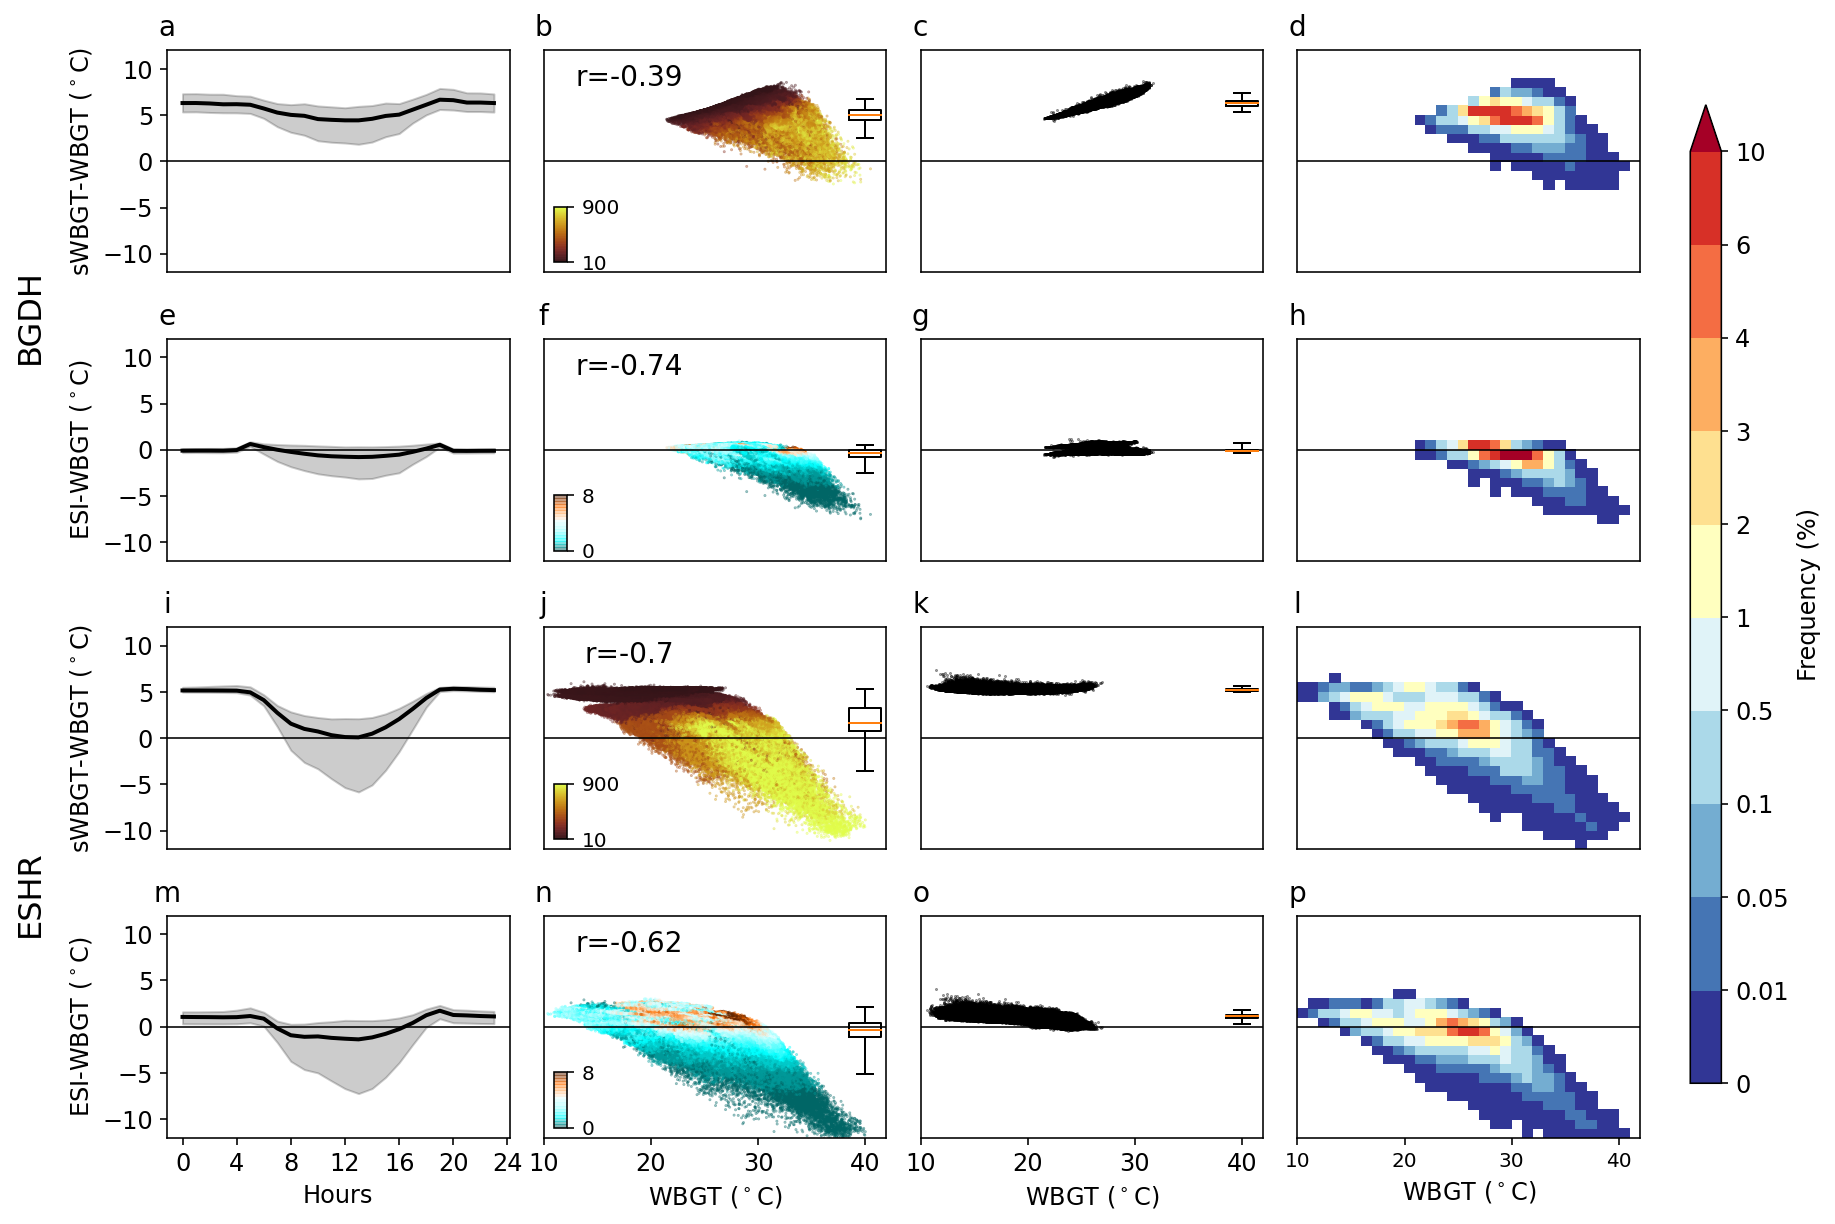

In [31]:
plot(diurnal_cycle, ts, freq)

# Figure caption:
Biases quantification for (a-d; i-l) sWBGT and (e-h; m-p) ESI over (a-h) the Bangladesh (23$^\circ$S-25$^\circ$N; 88-90$^\circ$E) and (i-p) east Sahara (22-24$^\circ$N; 24-26$^\circ$E). The diurnal cycle of biases is plotted in the leftmost column, with the shading area corresponding to 1 to 99th percentiles. Bias scattergrams for daytime and nighttime are plotted in the middle two columns with daytime on the left and nighttime on the right. Boxplots placed within scattergram describe bias spread with box extending from the lower to upper quartile and whiskers representing 1th and 99th percentiles. Daytime scattergram is colored by surface downward solar radiation (W/m$^2$) for sWBGT bias and 10m wind speed (m/s) for ESI bias. Bias frequency heatmap for both daytime and nighttime is plotted in the rightmost column. Data used cover the period 1990-2019 with only the hottest calendar month (defined by CMA WBGT) included.